<a href="https://www.kaggle.com/code/hatemamine/scotus-inference-and-evaluation?scriptVersionId=107192250" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install torchmetrics --quiet
import torch
from torchmetrics import F1Score
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random

#load the embedding for trainset to make support set 
with open('../input/scotus-embedding/embeddingsSCOTUStrain.pickle', 'rb') as handle:
    embeddings_train = pickle.load(handle)
print(embeddings_train.keys())
#load the embedding for validationset to make query set
with open('../input/scotus-embedding/embeddingsSCOTUSvalidation.pickle', 'rb') as handle:
    embeddings_validation = pickle.load(handle)
print(embeddings_validation.keys())

dict_keys(['embeddings_train', 'lable'])
dict_keys(['embeddings_validation', 'lable'])


In [2]:
import pandas
# counting unique values
numberofclass = len(pandas.unique(embeddings_train["lable"]))
print(numberofclass)

13


In [5]:
import numpy as np
class_weight = np.zeros(13)
for i in range(len(class_weight)):
    class_weight[i]=embeddings_train["lable"].count(i)/len(embeddings_train["lable"])
print(class_weight)
print(min(class_weight))

[0.2022 0.1622 0.0846 0.0386 0.009  0.007  0.051  0.2086 0.1434 0.0382
 0.0106 0.044  0.0006]
0.0006


In [6]:
def getsupportset(k):
    support_set=[]
    support_set_lable=[]
    print(k)
    for i in tqdm(range(numberofclass*k)):
        key =-1
        while key != i % numberofclass:
            ind = random.randint(0, len(embeddings_train["embeddings_train"])-1)
            key = embeddings_train["lable"][ind]
            if key == i % numberofclass:
                support_set_lable.append(key)
                #Compute cosine-similarities
                support_set.append(embeddings_train["embeddings_train"][ind])
    return support_set, support_set_lable
#support_set, support_set_lable = getsuportset_train(2)
#print(support_set_lable)


In [26]:
def getoptimalk(support_set, support_set_lable, unseenlabel):
    Xf1=[]
    for i in trange(1, 14):
        y_true_unseen=[]
        y_pred_unseen=[]
        y_true=[]
        y_pred=[]
        neigh = KNeighborsClassifier(n_neighbors=i)
        neigh.fit(support_set, support_set_lable)
        for j in range (len(embeddings_train["embeddings_train"])):
            if embeddings_train["lable"][j] in unseenlabel:
                y_true_unseen.append(embeddings_train["lable"][j])
                pred=(neigh.predict([embeddings_train["embeddings_train"][j]]))
                y_pred_unseen.append(pred[0])
            else:
                y_true.append(embeddings_train["lable"][j])
                pred=(neigh.predict([embeddings_train["embeddings_train"][j]]))
                y_pred.append(pred[0])
        #print(len(y_true))
        #print(len(y_pred))
        fscor=f1_score(y_true, y_pred, average='macro', zero_division=1)
        fscor_unseen=f1_score(y_true_unseen, y_pred_unseen, average='macro', zero_division=1)
        
        Xf1.append((fscor_unseen+fscor)/2)
    return max(Xf1), Xf1.index(max(Xf1))+1


In [27]:
x=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50]
koptim_KNN=[]
f1s_KNN=[]
for i in x:
    e, l =getsupportset(i)
    f1, k= getoptimalk(e, l, [0, 1])
    koptim_KNN.append(k)
    f1s_KNN.append(f1)
    

1


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

2


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

3


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

4


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

5


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

6


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

7


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

8


  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

9


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

10


  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

15


  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

20


  0%|          | 0/260 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

30


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

40


  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

50


  0%|          | 0/650 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

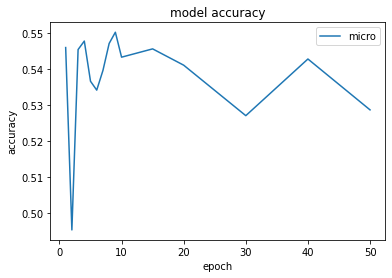

9
9


In [29]:
# plot k_knn and k_FSL with 
#plt.plot(x, koptim_KNN)
plt.plot(x, f1s_KNN)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['micro', 'macro'], loc='upper right')
plt.show()
print(f1s_KNN.index(max(f1s_KNN))+1)
#print(koptim[f1s.index(max(f1s))])
print(x[f1s_KNN.index(max(f1s_KNN))])


In [30]:
def gety_true_y_pred(x, k, nl=None):
        e, l =getsupportset(x)
        #print(len(e))
        y_true=[]
        y_pred=[]
        neigh = KNeighborsClassifier(n_neighbors=1)
        neigh.fit(e, l)
        if nl==None:
            for j in range (len(embeddings_validation["embeddings_validation"])):
                y_true.append(embeddings_validation["lable"][j])
                pred=neigh.predict([embeddings_validation["embeddings_validation"][j]])
                y_pred.append(pred[0])
        else:
            for j in range (len(embeddings_validation["embeddings_validation"])):
                if embeddings_validation["lable"][j]==nl:
                    y_true.append(embeddings_validation["lable"][j])
                    pred=(neigh.predict([embeddings_validation["embeddings_validation"][j]]))
                    y_pred.append(pred[0])
        return y_true, y_pred

In [37]:
y_true, y_pred= gety_true_y_pred(9, 9)

9


  0%|          | 0/117 [00:00<?, ?it/s]

In [38]:
f1 = F1Score(average='micro')
Ttrue_scores = torch.tensor(y_true)
Ttrue_scores = Ttrue_scores.long()
Tpredected_scores = torch.tensor(y_pred)
fmicro =f1(Tpredected_scores, Ttrue_scores)
f1 = F1Score(average='macro', num_classes= numberofclass)
fmacro =f1(Tpredected_scores, Ttrue_scores)
f1 = F1Score()
f1s =f1(Tpredected_scores, Ttrue_scores)
print("score micro is ", fmicro)
print("score macro is ", fmacro)
print("score macro is ", f1s)

score micro is  tensor(0.7093)
score macro is  tensor(0.6075)
score macro is  tensor(0.7093)


In [ ]:
x=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50]
f1s=[]
for i in x:
    e, l =getsupportset(i)
    f1= getSVMf1(e, l, [0, 1])
    f1s.append(f1)
    

In [ ]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
def getSVMf1(X, y, unseen):
    #SVC(gamma=2, C=1)
    y_pred=[]
    y_true=[]
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf.fit(X, y)
    for i in range(len(X)):
        if embeddings_validation["lable"][i] in unseen:
            y_pred.append(clf.predict([embeddings_validation["embeddings_validation"][i]]))
            y_true.append(embeddings_validation["lable"][i])
    fscor=f1_score(y_true, y_pred, average='macro', zero_division=1)
    return fscor

In [ ]:
def getSVMy_truey_pred(X, y):
    #SVC(gamma=2, C=1)
    y_pred=[]
    y_true=[]
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf.fit(X, y)
    y_pred=clf.predict(embeddings_validation["embeddings_validation"])
    y_true=embeddings_validation["lable"]
    return y_pred, y_true
e, l =getsupportset(1000)
y_pred, y_true =getSVMy_truey_pred(e, l)


In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
X = embeddings_train["embeddings_train"]
Y = embeddings_train["lable"]
gnb = GaussianNB()
y_pred = gnb.fit(X, Y).predict(embeddings_validation["embeddings_validation"])
y_true=embeddings_validation["lable"]



In [ ]:
y_true, y_pred= gety_true_y_pred(1, 1)

In [ ]:
cm = confusion_matrix(y_true, y_pred, labels=list(range(numberofclass)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(range(numberofclass)))
disp.plot()
plt.savefig("CM_SCOTUS.png")
plt.show()

In [ ]:
import umap
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

In [ ]:
e, l =getsuportset(1)
e=embeddings_validation["embeddings"]
l=embeddings_validation["lableskey"]
reducer = umap.UMAP(random_state=42)
reducer.fit(e)


In [ ]:
embedding = reducer.transform(e)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

In [ ]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=l, cmap='Spectral', s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(13)-1)
#plt.title('UMAP projection of the embedding words', fontsize=24);
plt.savefig("UMAP_Embedding_SCOTUS.png")


In [ ]:
f1 = F1Score(average='micro')
Ttrue_scores = torch.tensor(y_true)
Ttrue_scores = Ttrue_scores.long()
Tpredected_scores = torch.tensor(y_pred)
fmicro =f1(Tpredected_scores, Ttrue_scores)
f1 = F1Score(average='macro', num_classes= numberofclass)
fmacro =f1(Tpredected_scores, Ttrue_scores)
f1 = F1Score()
f1s =f1(Tpredected_scores, Ttrue_scores)
print("score micro is ", fmicro)
print("score macro is ", fmacro)
print("score macro is ", f1s)

In [ ]:
r0=[0.8958,0.5000, 0.0545, 0.7590, 0.6721]
r=[0.9083, 0.7248, 0.7207, 0.5810]
#bars = ('unseen 0', 'unseen 1','unseen  2', 'F1 micro', 'F1 macro')
bars = ('unseen label 0', 'unseen label 1', 'F1 micro', 'F1 macro')
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.bar(x_pos, r, color=(0.1, 0.1, 0.1, 0.1),  edgecolor='blue')
# Create names on the x-axis
plt.xticks(x_pos, bars)
plt.savefig("f1_SCOTUS.png")
# Show graph
plt.show()

In [ ]:
#plt.plot(X,  unseen1Xmicrof1  , marker='D', linewidth=6)

In [ ]:
fmicro=f1_score(y_true, y_pred, average='micro', zero_division=1)
fmacro=f1_score(y_true, y_pred, average='macro', zero_division=1)
print(fmicro, fmacro)